### Something is wrong!
### Something is wrong?
### Something is wrong!

### Ok. Before I can figure out what is wrong I need to get an idea for what IS.
Let's take a look at the data files. 
No, wait. Let's think about it for a minute, first.

Things that could be wrong:
    a) The data is wrong
        approach: Do sanity checks on the individual tables wrt data completeness and 'correctness'.
    b) The data shows me something is wrong with the people.
        approach: Do sanity checks on the patient-centric tables wrt my biased expectations of usage and illness rates
    c) The data shows me something is being done wrong For the people
        approach: Look at costs, rxes, procedures, encounter rates, and - if they're there - deaths
    d) All of the above
        approach: Whatever random stuff I do as digressions
    


In [124]:
## First things first:  some imports
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn
import sklearn
import glob

In [9]:
# A quick tour of ALL the tables
fnames = glob.glob("*.csv")
fnames

['medications.csv',
 'providers.csv',
 'imaging_studies.csv',
 'allergies.csv',
 'procedures.csv',
 'organizations.csv',
 'conditions.csv',
 'careplans.csv',
 'encounters.csv',
 'immunizations.csv',
 'patients.csv',
 'concepts.csv',
 'observations.csv']

In [29]:
# We all know this is the central table
pats = pd.read_csv("patients.csv")
n_patients = len(set(pats['Id'].values))
print(n_patients)

# Hm. Are there dupes?
print(len(pats)) 
# No! Good job, recordkeepers.



8360
8360


In [134]:
## What about dead folks?
deaths = pats['DEATHDATE'].count()
deaths

3360

In [ ]:
## SO we have a round 5000 folks. CONVENIENT.

In [135]:
## OK. Super naive data exploration time.
## How big are the tables
## how far back does data go
## how many (on super average) are there of *thing* per patient

patient_linked=[]
independent=[]
for fname in fnames:
    root= fname.split(".")[0]
    df = pd.read_csv(fname)
    print("There are ---> {} rows in the ---> {} table.".format(len(df), root.upper()))
    print("That's {} per patient".format(len(df)/n_patients))
    if len(df)<1000000:
        for date_word in ['START','STOP','DATE','BIRTHDATE','DEATHDATE']:
            if date_word in df.columns:
                df[date_word]=df[date_word].apply(pd.to_datetime)

                print("earliest {}: {}, latest date: {}".format(date_word, min(df[date_word]), max(df[date_word])))

    
        
    if 'PATIENT' in df.columns:
        patient_linked.append(root)
    else:
        independent.append(root)
    print()
    
print("TABLES JOINABLE TO PATIENT TABLE: {}".format(patient_linked))
print("DIM TABLES: {}".format(independent))

There are ---> 124759 rows in the ---> MEDICATIONS table.
That's 14.923325358851674 per patient
earliest START: 1909-11-26 00:00:00, latest date: 2019-05-06 00:00:00
earliest STOP: 1909-12-10 00:00:00, latest date: 2019-05-06 00:00:00

There are ---> 125 rows in the ---> PROVIDERS table.
That's 0.014952153110047847 per patient

There are ---> 8278 rows in the ---> IMAGING_STUDIES table.
That's 0.9901913875598086 per patient
earliest DATE: 1912-08-28 00:00:00, latest date: 2019-05-01 00:00:00

There are ---> 3262 rows in the ---> ALLERGIES table.
That's 0.3901913875598086 per patient
earliest START: 1909-08-21 00:00:00, latest date: 2019-04-14 00:00:00
earliest STOP: NaT, latest date: NaT

There are ---> 419399 rows in the ---> PROCEDURES table.
That's 50.16734449760766 per patient
earliest DATE: 1909-01-11 00:00:00, latest date: 2019-05-06 00:00:00

There are ---> 125 rows in the ---> ORGANIZATIONS table.
That's 0.014952153110047847 per patient

There are ---> 109720 rows in the ---> C

So I am super impressed with record keeping in Massandopolis, as it appears we have medical record information going back as far as 1908. 

I personally don't trust any information over 30, so we might have to ignore some of the old stuff later on.



... I think it's time to get to know the people of Massandopolis.

In [46]:
pats.head()

,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,LAST,SUFFIX,MAIDEN,MARITAL,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,CITY,STATE,ZIP
0,c0d528b6-cdae-4d98-8936-a270f8827eb7,2013-02-10,NaN,999-83-3170,NaN,NaN,NaN,Claudette391,Hahn503,NaN,NaN,NaN,white,french_canadian,F,Framingham Massandopolis US,239 Schaden Glen,Randolph,Massandopolis,2368.0
1,d709f84f-7d2c-440b-a979-2bc27d41f63a,1994-01-10,2019-01-07,999-31-7937,S99989196,X43239863X,Ms.,Christina143,Langworth352,NaN,NaN,NaN,black,dominican,F,Lynn Massandopolis US,535 Romaguera Annex Unit 82,Boston,Massandopolis,2108.0
2,92aa6efc-004f-4e01-b0be-9aafa40d9857,1989-08-27,NaN,999-59-2188,S99973592,X80581589X,Mrs.,Robbyn526,Eichmann909,NaN,Kohler843,M,hispanic,central_american,F,Salem Massandopolis US,986 Franecki Road Apt 37,Bellingham,Massandopolis,2019.0
3,f9b11b47-e8e8-4c3c-b279-36eba5086cfd,1988-10-09,NaN,999-48-9512,S99947146,X80365010X,Mr.,Earnest658,Bauch723,NaN,NaN,M,white,american,M,Concord Massandopolis US,451 Paucek Divide,Plymouth,Massandopolis,2360.0
4,c9d19013-4435-4b71-823a-c5023ba56195,1997-12-21,NaN,999-44-8705,S99938855,X28806996X,Mr.,Sung603,Schroeder447,NaN,NaN,NaN,white,polish,M,Reading Massandopolis US,123 Klocko Gateway,Natick,Massandopolis,1760.0


In [141]:
pats['BIRTHDATE']=pats['BIRTHDATE'].apply(pd.to_datetime)
pats['BIRTHYEAR']=pats['BIRTHDATE'].dt.year
pats['BIRTHDAY']=pats['BIRTHDATE'].dt.day
pats['BIRTHMONTH']=pats['BIRTHDATE'].dt.month


In [162]:
alive = pats[pats['DEATHDATE'].isnull()]
alive.name = 'alive'
dead = pats[pats['DEATHDATE'].notnull()]
dead.name = 'dead'
dead['DEATHYEAR']=dead['DEATHDATE'].apply(pd.to_datetime).dt.year


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [178]:
dead[dead['BIRTHYEAR']<1933][dead['GENDER']=='M']['DEATHYEAR'].value_counts()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1998    38
1996    33
2007    32
1999    32
2002    31
2006    31
1997    30
1994    30
2005    28
2003    27
2004    27
2011    27
1991    25
2009    25
1992    24
1995    24
2010    23
2013    23
2014    23
1990    22
1987    22
2008    22
2018    21
1981    20
2015    19
1989    19
2000    18
1988    18
1993    17
2001    17
        ..
1956     3
1957     3
1929     3
1932     2
1936     2
1937     2
1927     2
1923     2
1938     2
1940     2
1933     2
2019     2
1942     2
1958     2
1970     2
1964     2
1945     2
1959     2
1915     2
1954     2
1950     2
1949     2
1953     1
1951     1
1925     1
1965     1
1920     1
1919     1
1916     1
1961     1
Name: DEATHYEAR, Length: 97, dtype: int64

In [175]:
dead['BIRTHYEAR'].value_counts()

1929    304
1931    240
1930    200
1932    168
1913     99
1933     88
1935     79
1914     77
1941     74
1916     66
1924     66
1915     66
1923     55
1922     55
1937     52
1936     50
1938     47
1944     46
1939     45
1946     45
1919     44
1925     44
1921     44
1912     44
1910     44
1947     42
1953     41
1945     40
1940     39
1928     37
       ... 
1975      9
1989      9
1979      9
1977      9
1995      8
1991      8
1984      7
1993      7
1990      7
1992      6
2001      6
1985      6
2004      5
1988      4
1994      4
1982      4
2002      3
1997      3
1999      3
2013      3
2007      3
1996      2
2003      2
2000      2
2015      1
1998      1
2008      1
2010      1
2005      1
2012      1
Name: BIRTHYEAR, Length: 104, dtype: int64

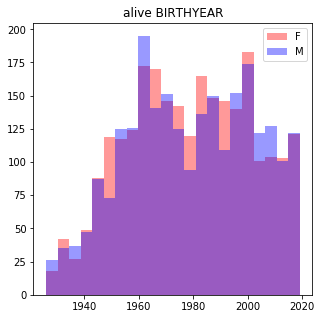

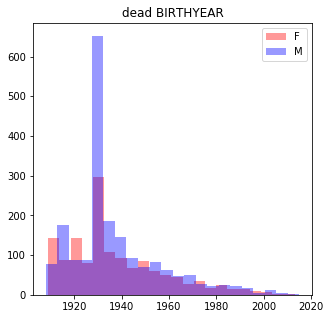

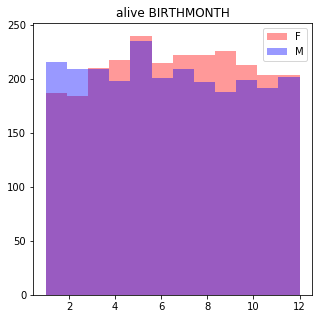

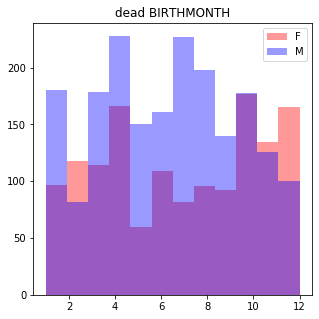

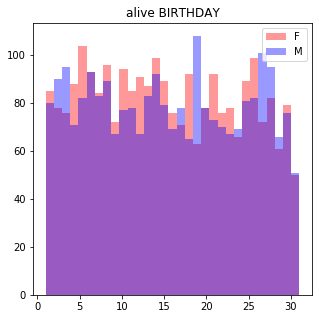

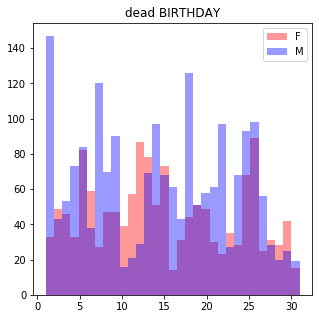

In [148]:
for sub_tup in [('BIRTHYEAR',22),('BIRTHMONTH',12),('BIRTHDAY',31)]:
    for status in [alive, dead]:
        bins = 12
        f=plt.figure(figsize=(5,5))
        plt.hist(status[status['GENDER']=='F'][sub_tup[0]], bins = sub_tup[1], color = 'r', alpha = 0.4, label='F')
        plt.hist(status[status['GENDER']=='M'][sub_tup[0]], bins = sub_tup[1], color = 'b', alpha = 0.4, label='M')
        plt.legend()
        plt.title(status.name + " "+ sub_tup[0])

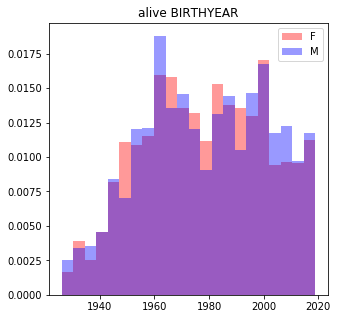

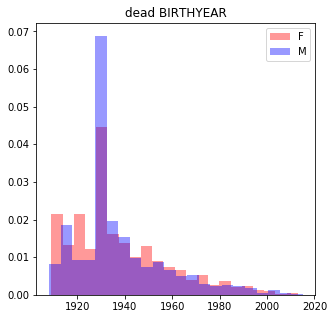

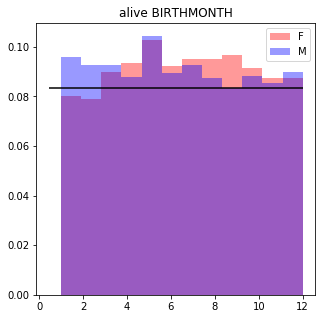

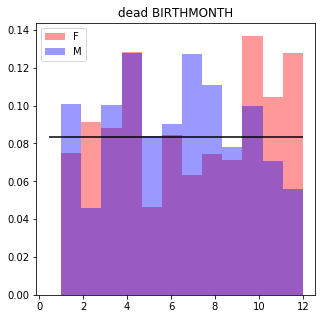

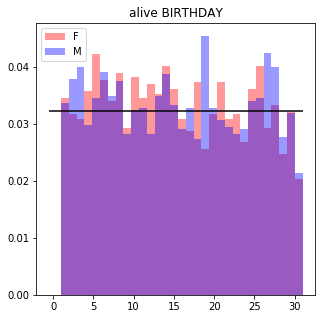

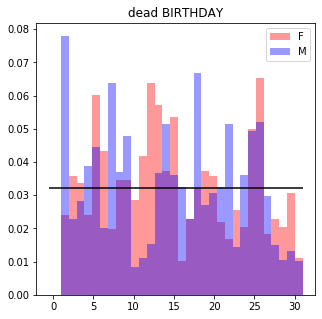

In [150]:
## OK so that's weird. Does it go away if I look at density instead of abs numbers?
for sub_tup in [('BIRTHYEAR',22),('BIRTHMONTH',12),('BIRTHDAY',31)]:
    for status in [alive, dead]:
        f=plt.figure(figsize=(5,5))
        plt.hist(status[status['GENDER']=='F'][sub_tup[0]], bins = sub_tup[1], color = 'r', alpha = 0.4, label='F', density=True)
        plt.hist(status[status['GENDER']=='M'][sub_tup[0]], bins = sub_tup[1], color = 'b', alpha = 0.4, label='M', density= True)
        xmin=plt.gca().get_xlim()[0]
        if sub_tup[0]!='BIRTHYEAR':
            plt.hlines(y=1/(sub_tup[1]), xmin=xmin, xmax = max(pats[sub_tup[0]].values))

        plt.legend()
        plt.title(status.name + " " + sub_tup[0])

In [182]:
alive['RACE'].value_counts()/len(alive)

white       0.7562
hispanic    0.1076
black       0.0716
asian       0.0604
native      0.0034
other       0.0008
Name: RACE, dtype: float64

In [183]:
dead['RACE'].value_counts()/len(dead)

white       0.717857
hispanic    0.150893
black       0.067560
asian       0.061905
native      0.001488
other       0.000298
Name: RACE, dtype: float64

In [ ]:
# HISPANIC FOLK DIE MORE? THE DIFF BTW 10-15% SEEMS VALID TO ME AT A GLANCE.
# IF I HAD MORE TIME I'D CHECK ON THEM MORE CLOSELY.

In [184]:
alive['GENDER'].value_counts()

F    2545
M    2455
Name: GENDER, dtype: int64

In [187]:
alive['MARITAL'].value_counts()

M    2679
S     653
Name: MARITAL, dtype: int64

### THOUGHTS ON PATIENTS

So, there appear to be a lot (A LOT) of men born in the late 30s here. A lot of people born in the late 30s, but way more men. THAT'S WEIRD.
I mean. They would have been too young for WW2 and Korea, too old for Vietnam, so here they are - demographic lottery winners?

All the same. There are MORE men than there are women from the 30s. And women of that age (so far as I know) still outsurvive men.
So are women dying extra here?

Wait. I have no idea if there are death records here!

Where would those even be?

...


Also why would there be more women than men born in the fall, and in the second week of the month in general?
The month and day stuff looks like if I checked closer it'd be maybe within range of normal variation, so I'm going to drop it for now. But those birth years though. What??



In [32]:
meds = pd.read_csv("medications.csv")

In [33]:
meds.head()

,START,STOP,PATIENT,ENCOUNTER,CODE,DESCRIPTION,COST,DISPENSES,TOTALCOST,REASONCODE,REASONDESCRIPTION
0,2013-12-07,2013-12-07,c0d528b6-cdae-4d98-8936-a270f8827eb7,06429fa8-52a8-4e07-bd6a-b102b136cfa6,312617,predniSONE 5 MG Oral Tablet,10.84,1,10.84,NaN,NaN
1,2013-12-20,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,4fa6e02b-272c-4469-8ef6-814ac1fab7ce,997488,Fexofenadine hydrochloride 30 MG Oral Tablet,25.72,65,1671.80,NaN,NaN
2,2013-12-20,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,4fa6e02b-272c-4469-8ef6-814ac1fab7ce,1870230,NDA020800 0.3 ML Epinephrine 1 MG/ML Auto-Inje...,470.29,65,30568.85,NaN,NaN
3,2014-12-03,2014-12-17,c0d528b6-cdae-4d98-8936-a270f8827eb7,2a24757d-039d-41d3-9570-4fe170c8a282,313782,Acetaminophen 325 MG Oral Tablet,5.40,1,5.40,10509002.0,Acute bronchitis (disorder)
4,2015-02-17,NaN,c0d528b6-cdae-4d98-8936-a270f8827eb7,6a95d43e-d1e5-4ab3-9a92-82f287b64f5d,895994,120 ACTUAT Fluticasone propionate 0.044 MG/ACT...,36.63,51,1868.13,233678006.0,Childhood asthma


In [34]:
meds['STOP'].values[0]

'2013-12-07'